In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score, mean_squared_error  
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import optuna

In [2]:
import os
import re

In [3]:
from perform_visualization import perform_eda, perform_eda_short, performance_visualizations

In [4]:
random_seed = 42
early_stopping_round = 100

In [5]:
stat_path = os.path.join(os.getcwd())
pattern = re.compile(r'output_*\d')
folder_paths =[]
for folder_name in os.listdir(stat_path):
    if pattern.match(folder_name):
        folder_paths.append(folder_name)

In [6]:
filename_features = "features_full.csv"
filename_target = "target_full.csv"

In [7]:
X = pd.DataFrame()
y = pd.DataFrame()
for folder in folder_paths:
    X_tmp = pd.read_csv(os.getcwd() + "/" + folder + "/" + filename_features)
    y_tmp = pd.read_csv(os.getcwd() + "/" + folder + "/" + filename_target)
    
    is_unnamed = pd.isna(X_tmp.columns[0]) or str(X_tmp.columns[0]).startswith('Unnamed:')
    is_unnamed_y = pd.isna(y_tmp.columns[0]) or str(y_tmp.columns[0]).startswith('Unnamed:')
    if is_unnamed:
        X_tmp = X_tmp.drop(X_tmp.columns[0], axis=1)
    if is_unnamed_y:
        y_tmp = y_tmp.drop(y_tmp.columns[0], axis=1)
    
    if X_tmp.columns[0] != "y":
        col_y = np.ones(X_tmp.shape[0]) * 1000
        X_tmp.insert(0, "y", col_y)
    
    print(X_tmp.shape, y_tmp.shape)
    X = pd.concat([X, X_tmp], axis = 0)
    y = pd.concat([y, y_tmp], axis = 0)
X.reset_index(inplace=True, drop=True)
y.reset_index(inplace=True, drop=True)
X.shape, y.shape

(179712, 9) (179712, 4)
(105600, 9) (105600, 4)
(1034880, 9) (1034880, 4)


((1320192, 9), (1320192, 4))

## EDA

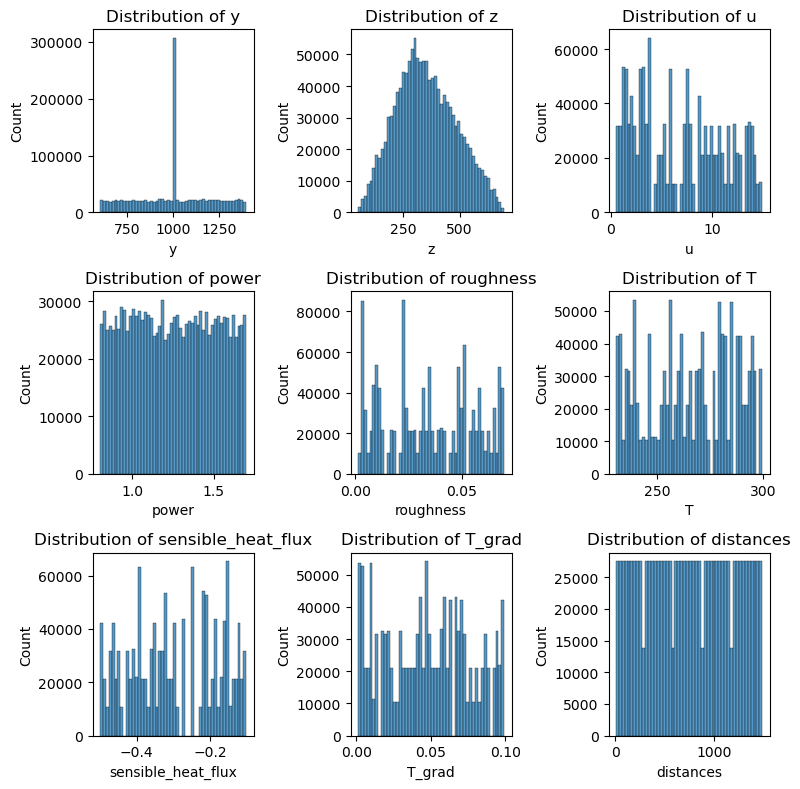

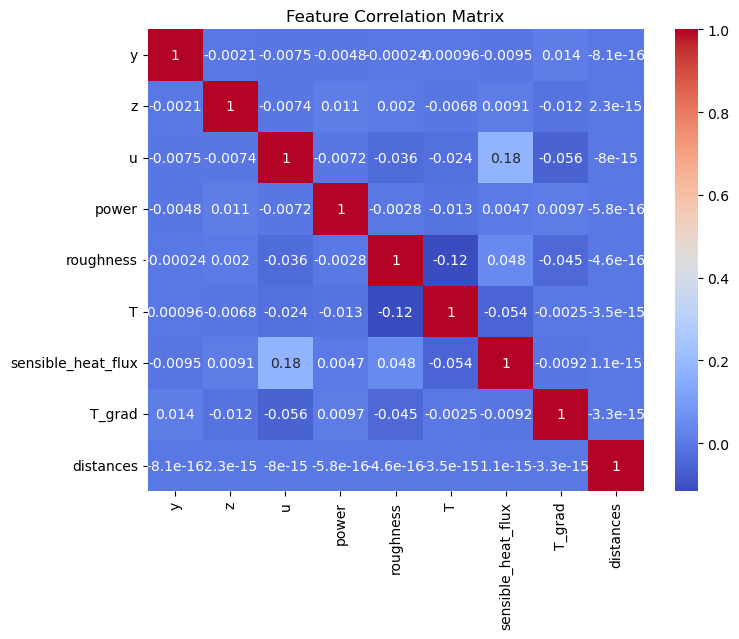

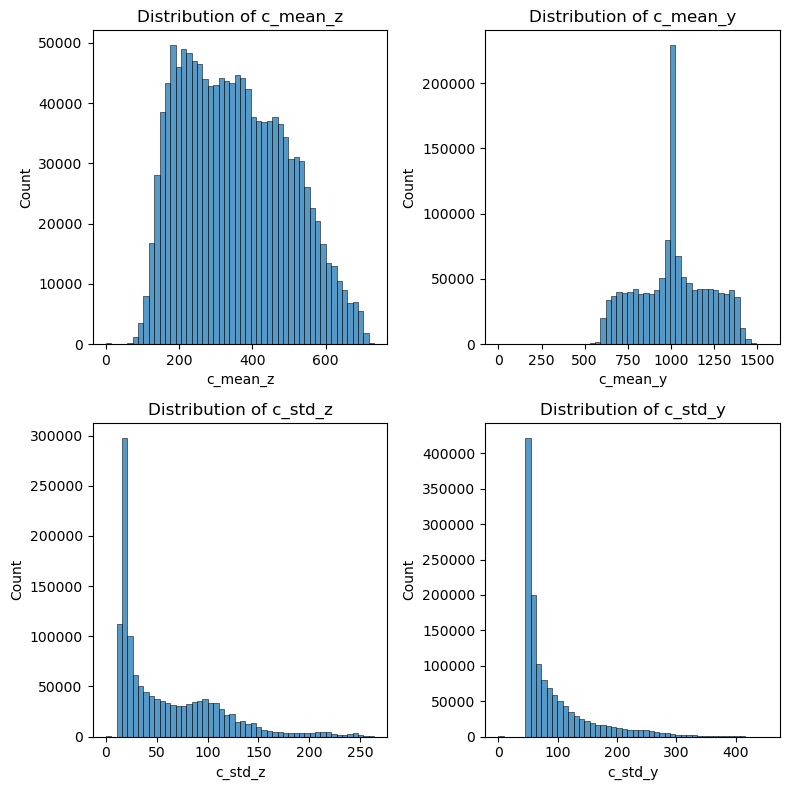

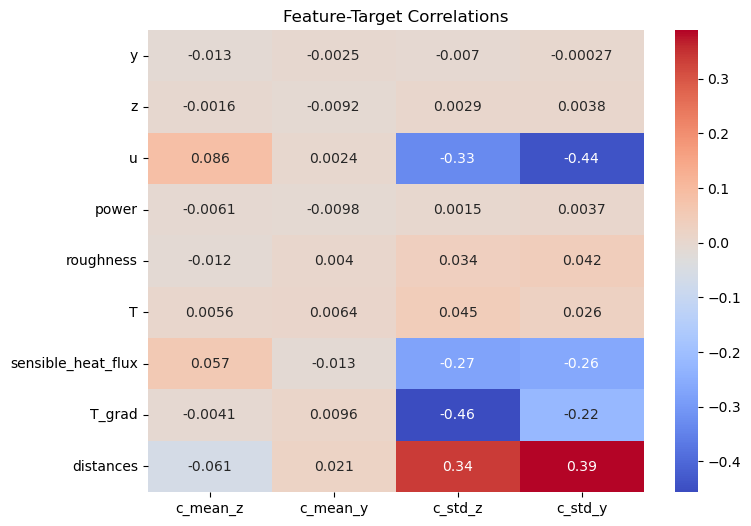

In [8]:
perform_eda(X, y)

## Test-train split

In [9]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=random_seed)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.1, random_state=random_seed)

In [11]:
# for small dataset
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.1, random_state=random_seed)

In [12]:
# for small dataset
X_train.shape, y_train.shape, X_eval.shape, y_eval.shape

((760429, 9), (760429, 4), (84493, 9), (84493, 4))

In [13]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_eval.shape, y_eval.shape

((760429, 9), (760429, 4), (211231, 9), (211231, 4), (84493, 9), (84493, 4))

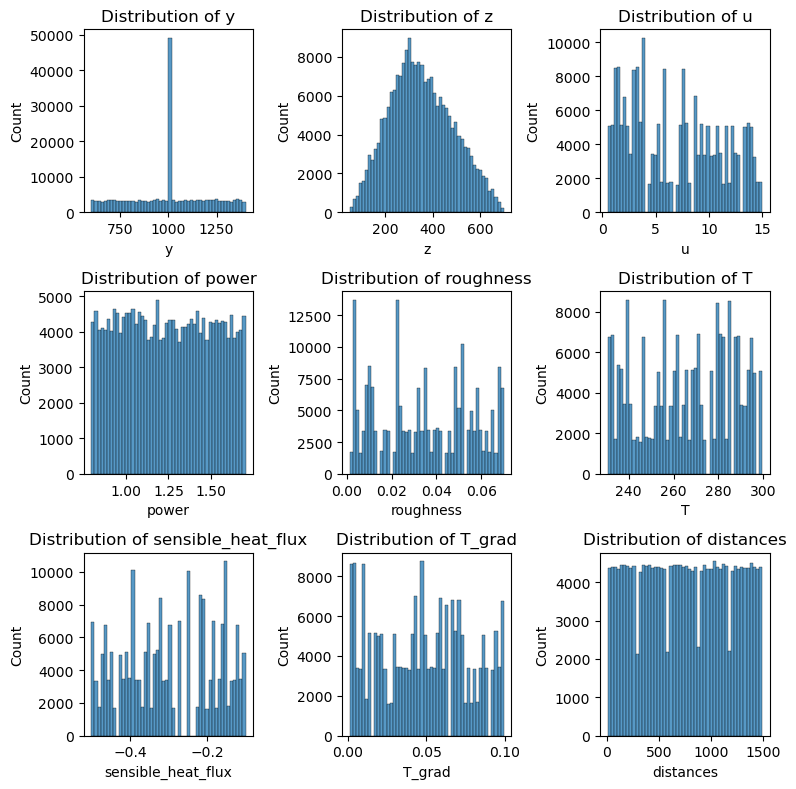

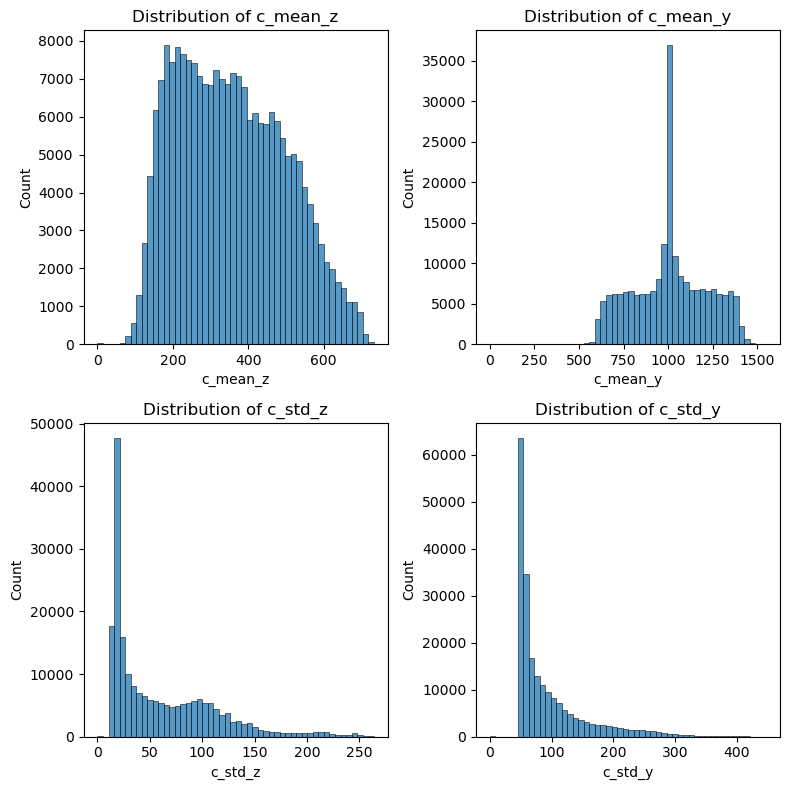

In [14]:
perform_eda_short(X_test, y_test)

## Feature engineering

In [15]:
#Train Mean Standartization
y_train["c_mean_y"]-=X_train["y"]
y_train["c_mean_z"]-=X_train["z"]

y_train["c_mean_y"] = (y_train["c_mean_y"] - np.mean(y_train["c_mean_y"]))/(np.std(y_train["c_mean_y"]))
y_train["c_mean_z"] = (y_train["c_mean_z"] - np.mean(y_train["c_mean_z"]))/(np.std(y_train["c_mean_z"]))


In [16]:
# Test Mean Standartization
y_test["c_mean_y"]-=X_test["y"]
y_test["c_mean_z"]-=X_test["z"]

y_test["c_mean_y"] = (y_test["c_mean_y"] - np.mean(y_test["c_mean_y"]))/(np.std(y_test["c_mean_y"]))
y_test["c_mean_z"] = (y_test["c_mean_z"] - np.mean(y_test["c_mean_z"]))/(np.std(y_test["c_mean_z"]))

In [17]:
# Train feature Standartization
X_train["y"]=(X_train["y"] - np.mean(X_train["y"]))/(np.std(X_train["y"]))
X_train["z"]=(X_train["z"] - np.mean(X_train["z"]))/(np.std(X_train["z"]))

In [18]:
#Delete zeros in train
X_train = X_train[y_train["c_std_y"] != 0]
X_train = X_train[y_train["c_std_z"] != 0]

y_train = y_train[y_train["c_std_z"] != 0]
y_train = y_train[y_train["c_std_y"] != 0]

/tmp/ipykernel_127021/3768976045.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train = X_train[y_train["c_std_z"] != 0]


In [19]:
#Train std logarighm
y_train["c_std_y"] = np.log(y_train["c_std_y"])
y_train["c_std_z"] = np.log(y_train["c_std_z"])

In [20]:
#Delete zeros in test
X_test = X_test[y_test["c_std_y"] != 0]
X_test = X_test[y_test["c_std_z"] != 0]

y_test = y_test[y_test["c_std_z"] != 0]
y_test = y_test[y_test["c_std_y"] != 0]

/tmp/ipykernel_127021/2842488162.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_test = X_test[y_test["c_std_z"] != 0]


In [21]:
#Test std logarighm
y_test["c_std_y"] = np.log(y_test["c_std_y"])
y_test["c_std_z"] = np.log(y_test["c_std_z"])

In [22]:
# for eval
y_eval["c_mean_y"]-=X_eval["y"]
y_eval["c_mean_z"]-=X_eval["z"]

y_eval["c_mean_y"] = (y_eval["c_mean_y"] - np.mean(y_eval["c_mean_y"]))/(np.std(y_eval["c_mean_y"]))
y_eval["c_mean_z"] = (y_eval["c_mean_z"] - np.mean(y_eval["c_mean_z"]))/(np.std(y_eval["c_mean_z"]))

X_eval = X_eval[y_eval["c_std_y"] != 0]
X_eval = X_eval[y_eval["c_std_z"] != 0]

y_eval = y_eval[y_eval["c_std_z"] != 0]
y_eval = y_eval[y_eval["c_std_y"] != 0]

y_eval["c_std_y"] = np.log(y_eval["c_std_y"])
y_eval["c_std_z"] = np.log(y_eval["c_std_z"])

/tmp/ipykernel_127021/1211021379.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_eval = X_eval[y_eval["c_std_z"] != 0]


## Models

### Constant model

In [23]:
y_pred = {}
for target in y_train.columns:
    y_pred[target] = np.mean(y_train[target]) * np.ones(len(y_test[target]))

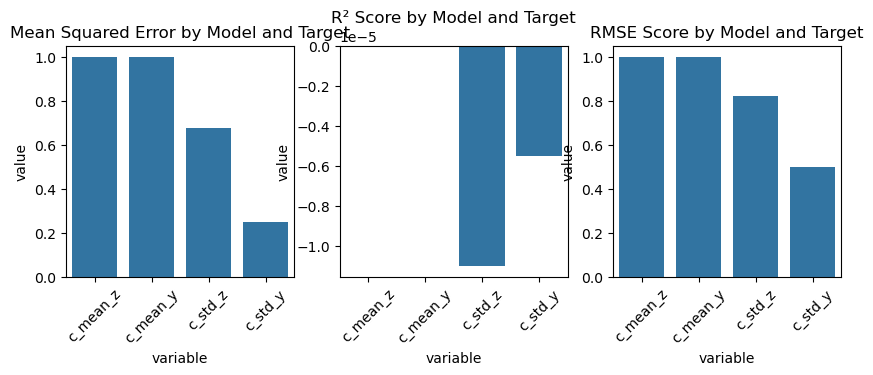

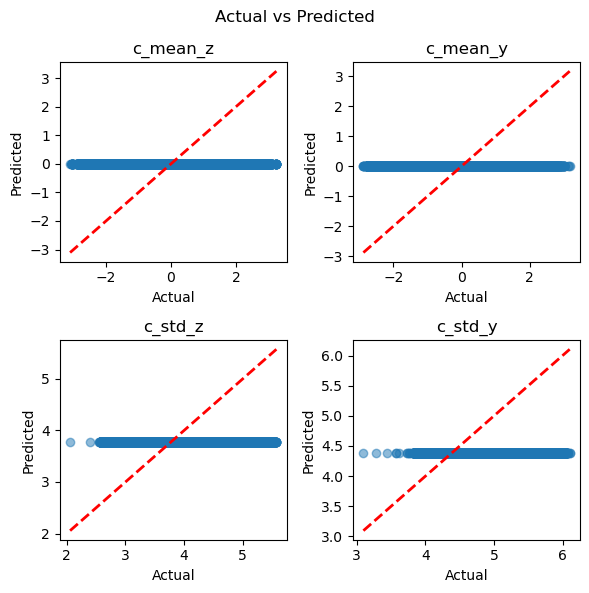

               mse            r2      rmse
c_mean_z  0.999752 -4.244938e-10  0.999876
c_mean_y  0.998702 -8.963563e-11  0.999351
c_std_z   0.677738 -1.100023e-05  0.823248
c_std_y   0.250918 -5.503715e-06  0.500917


In [24]:
performance_visualizations(y_pred, y_test)

### Random model

In [25]:
y_pred = {}
for target in y_train.columns:
    y_pred[target] = np.random.normal(np.min(y_train[target]), np.max(y_train[target]), len(y_test))

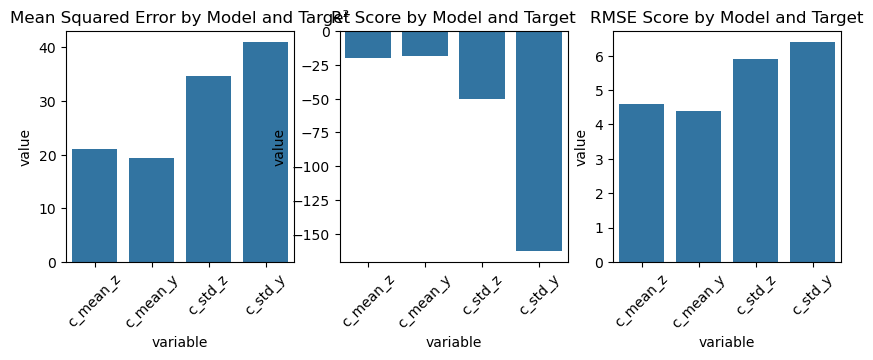

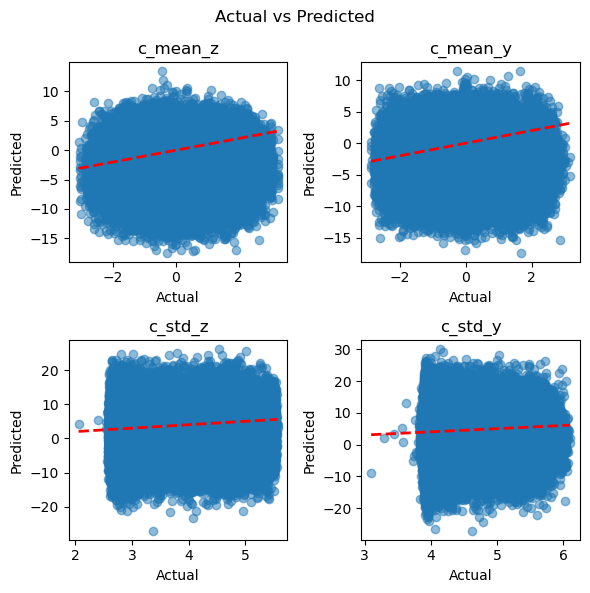

                mse          r2      rmse
c_mean_z  21.077029  -20.082248  4.590973
c_mean_y  19.379349  -18.404531  4.402198
c_std_z   34.715983  -50.223878  5.892027
c_std_y   41.010023 -162.440898  6.403907


In [26]:
performance_visualizations(y_pred, y_test)

## Catboost with optuna

In [27]:
def objective(trial):
    param = {
        'learning_rate': trial.suggest_float("learning_rate", 0.001, 0.02),
        'depth': trial.suggest_int('depth', 1, 15),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0, 3.0),
        'min_child_samples': trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32]),
        'grow_policy': 'Depthwise',
        'iterations': 300,
        'use_best_model': True,
        'eval_metric': 'MultiRMSE',
        'loss_function': 'MultiRMSE',
        'od_type': 'iter',
        # 'task_type': "GPU",
        # 'devices': '0',
        'od_wait': 20,
        'random_state': random_seed,
        'logging_level': 'Silent'
    }
    regressor = CatBoostRegressor(**param)

    regressor.fit(X_train.copy(), y_train.copy(),
                  eval_set=[(X_eval.copy(), y_eval.copy())],
                  early_stopping_rounds=early_stopping_round)
    loss = root_mean_squared_error(y_valid, regressor.predict(X_valid.copy()))
    return loss

In [28]:
# %%time
# study = optuna.create_study(study_name=f'catboost-seed{random_seed}')
# study.optimize(objective, n_trials=1000, n_jobs=-1, timeout=7200)

In [29]:
# print(study.best_value)
# print(study.best_params)

In [30]:
best_params = {'learning_rate': 0.0199640131584563, 'depth': 15, 'l2_leaf_reg': 1.8809696508799658, 'min_child_samples': 16}

In [31]:
%%time
y_pred ={}
for target in y_train.columns:
    
    optimized_regressor = CatBoostRegressor(learning_rate=best_params['learning_rate'],
                                            depth=best_params['depth'],
                                            l2_leaf_reg=best_params['l2_leaf_reg'],
                                            min_child_samples=best_params['min_child_samples'],
                                            grow_policy='Depthwise',
                                            iterations=1000,
                                            use_best_model=True,
                                            eval_metric='RMSE',
                                            loss_function= 'RMSE',
                                            thread_count = -1,
                                            od_type='iter',
                                            od_wait=20,
                                            random_state=random_seed,
                                            logging_level='Silent')
    optimized_regressor.fit(X_train.copy(), y_train[target].copy(),
                            eval_set=[(X_eval.copy(), y_eval[target].copy())],
                            early_stopping_rounds=early_stopping_round)
    y_pred_tmp = optimized_regressor.predict(X_test.copy())
    y_pred[target] = y_pred_tmp 

CPU times: user 5h 6min 59s, sys: 3h 25min 35s, total: 8h 32min 34s
Wall time: 10min 6s


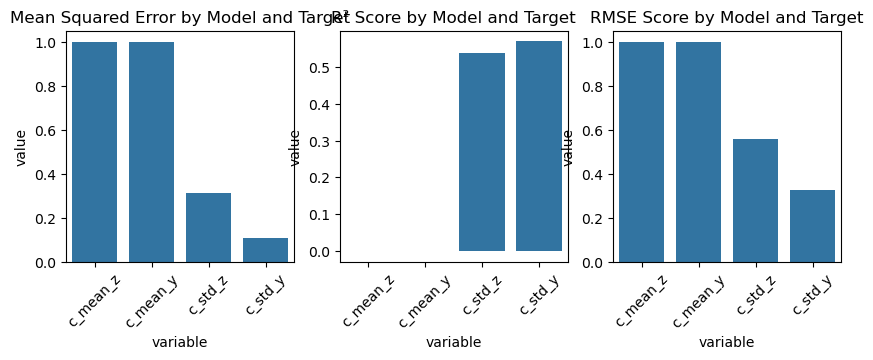

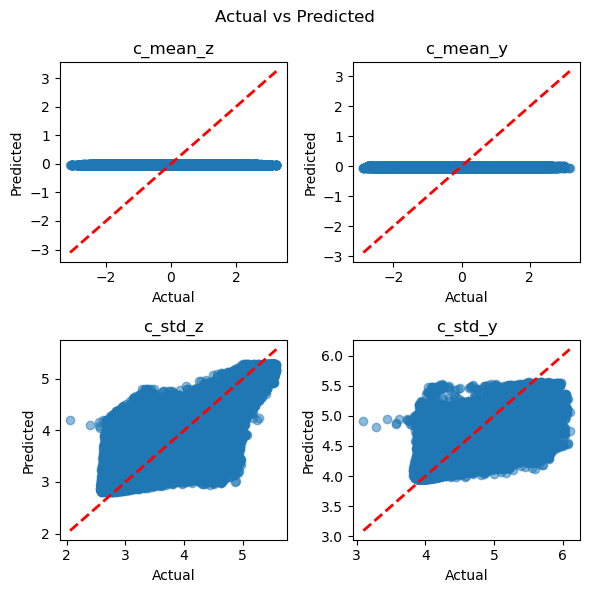

               mse        r2      rmse
c_mean_z  1.000991 -0.001238  1.000495
c_mean_y  0.999642 -0.000941  0.999821
c_std_z   0.313101  0.538015  0.559554
c_std_y   0.107946  0.569794  0.328551


In [32]:
performance_visualizations(y_pred, y_test)

In [33]:
rf_model = RandomForestRegressor()

In [34]:
y_pred = {}
for target in y_train.columns:
    rf_model.fit(X_train, y_train[target])
    y_tmp = rf_model.predict(X_test)
    y_pred[target] = y_tmp

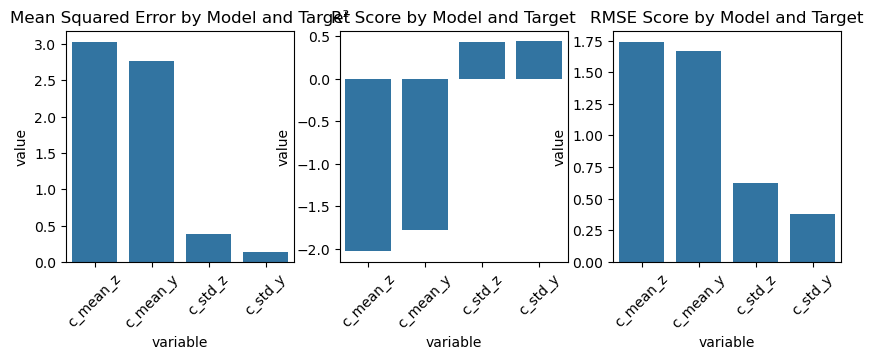

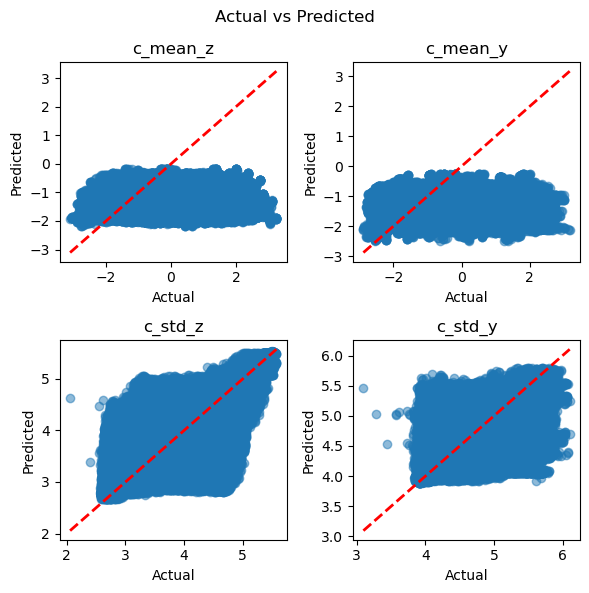

               mse        r2      rmse
c_mean_z  3.031151 -2.031901  1.741020
c_mean_y  2.773976 -1.777581  1.665526
c_std_z   0.386808  0.429260  0.621939
c_std_y   0.140631  0.439532  0.375008


In [35]:
performance_visualizations(y_pred, y_test)

## NN

In [36]:
from sklearn.neural_network import MLPRegressor

In [37]:
mlp_model = MLPRegressor()
y_pred = {}
for target in y_train.columns:
    rf_model.fit(X_train, y_train[target])
    y_tmp = rf_model.predict(X_test)
    y_pred[target] = y_tmp

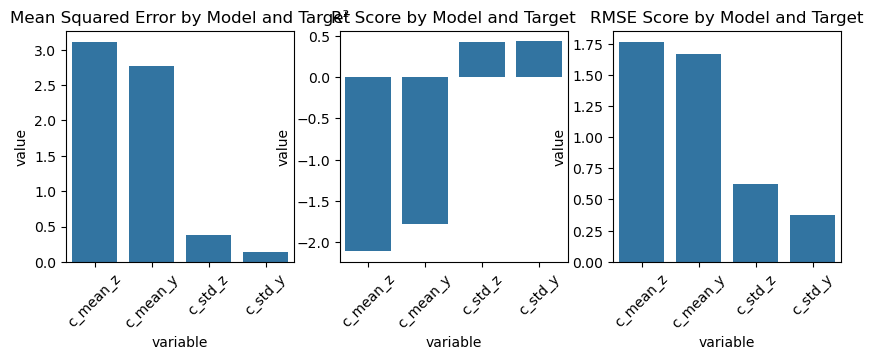

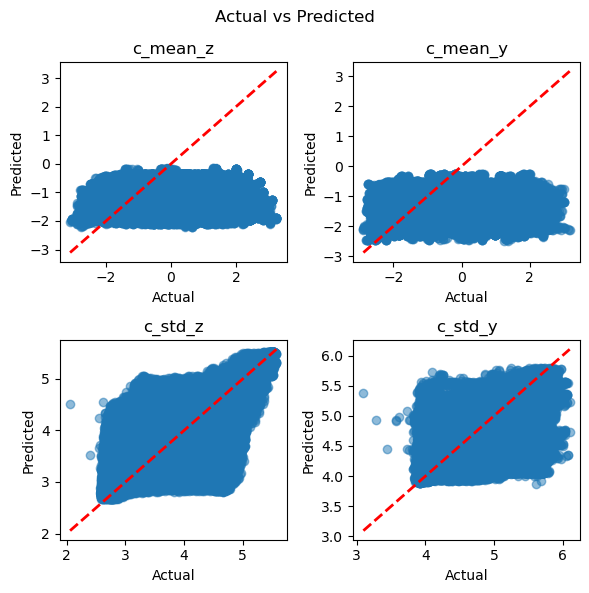

               mse        r2      rmse
c_mean_z  3.111740 -2.112511  1.764013
c_mean_y  2.775376 -1.778983  1.665946
c_std_z   0.384930  0.432031  0.620427
c_std_y   0.142001  0.434069  0.376831


In [38]:
performance_visualizations(y_pred, y_test)